In [1]:
# uncomment this to use pyspark in google colab

# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
# !tar zxvf spark-3.3.1-bin-hadoop3.tgz

spark-3.3.1-bin-hadoop3/
spark-3.3.1-bin-hadoop3/LICENSE
spark-3.3.1-bin-hadoop3/NOTICE
spark-3.3.1-bin-hadoop3/R/
spark-3.3.1-bin-hadoop3/R/lib/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.1-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/hsearch.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/links.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/nsInfo.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/package.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/vignette.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/NAMESPACE
spark-3.3.1-bin-hadoop3/R/lib/SparkR/R/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/R/SparkR
spark-3.3.1-bin-hadoop3/R/lib/SparkR/R/SparkR.rdb
spark-3.3.1-bin-hadoop3/R/lib/SparkR/R/SparkR.rdx
spark-3.3.1-bin-hadoop3/R/lib/SparkR/doc/
spark-3.3.1-bin-hadoop3/R/lib/Spar

In [1]:
# uncomment this to use pyspark in google colab
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = '/content/spark-3.3.1-bin-hadoop3'

In [2]:
# uncomment this to use pyspark in google colab
# !pip install -q findspark
# import findspark
# findspark.init()
# findspark.find()

'/content/spark-3.3.1-bin-hadoop3'

In [3]:
import os
import sys

SPARK_HOME = os.environ["SPARK_HOME"]

In [4]:
import pyspark
from pyspark.sql import SparkSession

conf = pyspark.SparkConf()
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

### Reading all data

In [5]:
df_train = spark.read.csv("./train.csv", header=True, multiLine=True, inferSchema=True, escape='"', sep=',', encoding="utf8")
df_train.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- toxic: integer (nullable = true)
 |-- severe_toxic: integer (nullable = true)
 |-- obscene: integer (nullable = true)
 |-- threat: integer (nullable = true)
 |-- insult: integer (nullable = true)
 |-- identity_hate: integer (nullable = true)



In [6]:
df_test = spark.read.csv("./test.csv", header=True, multiLine=True, inferSchema=True, escape='"', sep=',', encoding="utf8")
df_test.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)



In [7]:
df_labels = spark.read.csv("./test_labels.csv", header=True, multiLine=True, inferSchema=True, escape='"', sep=',', encoding="utf8")
df_labels.printSchema()

root
 |-- id: string (nullable = true)
 |-- toxic: integer (nullable = true)
 |-- severe_toxic: integer (nullable = true)
 |-- obscene: integer (nullable = true)
 |-- threat: integer (nullable = true)
 |-- insult: integer (nullable = true)
 |-- identity_hate: integer (nullable = true)



### Preprocess data

In [8]:
df_test = df_test.join(df_labels, df_test.id == df_labels.id, "inner")

In [9]:
df_train.createOrReplaceTempView("train_comments")
comments_with_labels = spark.sql("SELECT comment_text, toxic FROM train_comments")

df_test.createOrReplaceTempView("test_comments")
comments_test = spark.sql("SELECT comment_text, toxic FROM test_comments")

In [10]:
from pyspark.sql.types import IntegerType

# convert toxic label to int
comments_with_labels = comments_with_labels.withColumn("toxic", comments_with_labels["toxic"].cast(IntegerType()))
comments_test = comments_test.withColumn("toxic", comments_test["toxic"].cast(IntegerType()))

In [11]:
# deleting unlabeled data
comments_test = comments_test.filter(comments_test.toxic != -1)

In [12]:
from pyspark.sql.functions import regexp_replace

def clear_data(data):
    # delete enter
    data = data.select("toxic", regexp_replace("comment_text", "\n", " ").alias("comment_text"))
    # delete urls
    data = data.select("toxic", regexp_replace("comment_text", "https?://\S+|www\.\S+", "").alias("comment_text"))
    # delete ip address
    data = data.select("toxic", regexp_replace("comment_text", "\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", "").alias("comment_text"))
    # delete double quotes
    data = data.select("toxic", regexp_replace("comment_text", "\"\"", "\"").alias("comment_text"))
    data = data.select("toxic", regexp_replace("comment_text", "^\"", "").alias("comment_text"))
    data = data.select("toxic", regexp_replace("comment_text", "\"$", "").alias("comment_text"))
    # delete punctuation
    data = data.select("toxic", regexp_replace("comment_text", "[^a-zA-Z0-9]+", " ").alias("comment_text"))
    # delete many spaces
    data = data.select("toxic", regexp_replace("comment_text", "\s\s+", "").alias("comment_text"))
    # delete tags html
    data = data.select("toxic", regexp_replace("comment_text", "<.*?>", "").alias("comment_text"))
    # delete spaces at the beggining
    data = data.select("toxic", regexp_replace("comment_text", "^\s", "").alias("comment_text"))
    return data

In [13]:
import pyspark.sql.functions as F

# due to imbalanced data randomly get data with label 0 sample with the size = test_size / train_size * coeff
# coeff - another hyperparameter (I use 1.2)
def make_df_equal_sizes(data):
    data_sample = data.filter(data.toxic == 0).sample(False, data.filter(data.toxic == 1).count() / data.filter(data.toxic == 0).count() * 1.2, seed=42)
    combined_df = data.filter(data.toxic == 1).unionAll(data_sample)
    combined_df = combined_df.select("*").orderBy(F.rand())
    return combined_df

In [14]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import NGram
from pyspark.ml import Pipeline

# pipeline to preprocess
def make_pipeline(numFeatures=262144):
    stop_words = ["the", "is", "are", "am", "to", " ", "\n", "t", "m", "re", "ll", "s"]
    tokenizer = Tokenizer(inputCol="comment_text", outputCol="comment_words")
    stopwordsRemover = StopWordsRemover(inputCol="comment_words", outputCol="filtered_words", stopWords=stop_words)
    ngram = NGram(n=1, inputCol="filtered_words", outputCol="ngram_words")
    hashingTF = HashingTF(inputCol="ngram_words", outputCol="comment_words_tf", numFeatures=numFeatures)
    idf = IDF(inputCol="comment_words_tf", outputCol="comment_words_tfidf")
    pipeline = Pipeline(stages=[tokenizer, stopwordsRemover, ngram, hashingTF, idf])
    return pipeline

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# count rocauc and accuracy
def print_metrics(model, data, part="Train"):
    preds = model.transform(data)
    bce = BinaryClassificationEvaluator(labelCol="toxic")
    mce = MulticlassClassificationEvaluator(labelCol="toxic")
    print(f"{part} rocauc: {str(bce.evaluate(preds, {bce.metricName: 'areaUnderROC'}))}")
    print(f"{part} accuracy: {str(mce.evaluate(preds, {mce.metricName: 'accuracy'}))}")
    return {"rocauc": bce.evaluate(preds, {bce.metricName: 'areaUnderROC'}),
           "accuracy": mce.evaluate(preds, {mce.metricName: 'accuracy'})}

In [16]:
def train_and_test(pipeline, model, train_data, test_data):
    metrics = {}
    train_data = clear_data(train_data)
    train_data = make_df_equal_sizes(train_data)
    print(model)
    fitted_pipeline = pipeline.fit(train_data)
    dataset = fitted_pipeline.transform(train_data)
    fitted_model = model.fit(dataset)
    metrics["train"] = print_metrics(fitted_model, dataset, "Train")
    test_data = clear_data(test_data)
    test_dataset = fitted_pipeline.transform(test_data)
    metrics["test"] = print_metrics(fitted_model, test_dataset, "Test")
    return fitted_model, fitted_pipeline, metrics

In [17]:
pipeline = make_pipeline()

### Logistic Regression

In [18]:
%%time

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="comment_words_tfidf", labelCol="toxic", maxIter=100, regParam=1.0)

train_and_test(pipeline, lr, comments_with_labels, comments_test)

LogisticRegression_4ed78baede9a
Train rocauc: 0.9842587372091977
Train accuracy: 0.9315239710740113
Test rocauc: 0.8437916848774732
Test accuracy: 0.7735940479539842
CPU times: user 824 ms, sys: 134 ms, total: 959 ms
Wall time: 2min 13s


(LogisticRegressionModel: uid=LogisticRegression_4ed78baede9a, numClasses=2, numFeatures=262144,
 PipelineModel_a52d576cfb6e,
 {'train': {'rocauc': 0.9842574765752595, 'accuracy': 0.9315239710740113},
  'test': {'rocauc': 0.8437916848774732, 'accuracy': 0.7735940479539842}})

### Linear SVM

In [19]:
%%time

from pyspark.ml.classification import LinearSVC

svm = LinearSVC(featuresCol="comment_words_tfidf", labelCol="toxic", maxIter=100, regParam=1.0)
train_and_test(pipeline, svm, comments_with_labels, comments_test)

LinearSVC_4d6219b94595
Train rocauc: 0.9869465498281103
Train accuracy: 0.8931940600541618
Test rocauc: 0.8357227543068276
Test accuracy: 0.6224014504986088
CPU times: user 860 ms, sys: 138 ms, total: 998 ms
Wall time: 2min 29s


(LinearSVCModel: uid=LinearSVC_4d6219b94595, numClasses=2, numFeatures=262144,
 PipelineModel_39cedb59f323,
 {'train': {'rocauc': 0.9869460159335677, 'accuracy': 0.8931940600541618},
  'test': {'rocauc': 0.8357227543068276, 'accuracy': 0.6224014504986088}})

### Multionomial logistic regression

In [20]:
%%time

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="comment_words_tfidf", labelCol="toxic", maxIter=100, regParam=1.0, family="multinomial")

train_and_test(pipeline, lr, comments_with_labels, comments_test)

LogisticRegression_b8bc471f6151
Train rocauc: 0.9883849474365282
Train accuracy: 0.9358093027408267
Test rocauc: 0.8408527244388343
Test accuracy: 0.7464284597830504
CPU times: user 905 ms, sys: 145 ms, total: 1.05 s
Wall time: 2min 50s


(LogisticRegressionModel: uid=LogisticRegression_b8bc471f6151, numClasses=2, numFeatures=262144,
 PipelineModel_8df6f53a357b,
 {'train': {'rocauc': 0.9883831761208534, 'accuracy': 0.9358093027408267},
  'test': {'rocauc': 0.8408527244388343, 'accuracy': 0.7464284597830504}})

### Trying different feature numbers

In [21]:
feature_nums = [10, 100, 500, 1000, 5000, 10_000]

auc_roc = {"logreg": {"train": [], "test": []}, "svm": {"train": [], "test": []}, "multilogreg": {"train": [], "test": []}}
accuracy = {"logreg": {"train": [], "test": []}, "svm": {"train": [], "test": []}, "multilogreg": {"train": [], "test": []}}

for feature_num in feature_nums:
    print("feature_num = ", feature_num)
    pipeline = make_pipeline(feature_num)
    lr = LogisticRegression(featuresCol="comment_words_tfidf", labelCol="toxic", maxIter=100, regParam=1.0)
    _, _, metrics = train_and_test(pipeline, lr, comments_with_labels, comments_test)
    auc_roc["logreg"]["train"].append((feature_num, metrics["train"]["rocauc"]))
    accuracy["logreg"]["train"].append((feature_num, metrics["train"]["accuracy"]))
    auc_roc["logreg"]["test"].append((feature_num, metrics["test"]["rocauc"]))
    accuracy["logreg"]["test"].append((feature_num, metrics["test"]["accuracy"]))
    svm = LinearSVC(featuresCol="comment_words_tfidf", labelCol="toxic", maxIter=100, regParam=1.0)
    _, _, metrics = train_and_test(pipeline, svm, comments_with_labels, comments_test)
    auc_roc["svm"]["train"].append((feature_num, metrics["train"]["rocauc"]))
    accuracy["svm"]["train"].append((feature_num, metrics["train"]["accuracy"]))
    auc_roc["svm"]["test"].append((feature_num, metrics["test"]["rocauc"]))
    accuracy["svm"]["test"].append((feature_num, metrics["test"]["accuracy"]))
    lr = LogisticRegression(featuresCol="comment_words_tfidf", labelCol="toxic", maxIter=100, regParam=1.0, family="multinomial")
    _, _, metrics = train_and_test(pipeline, lr, comments_with_labels, comments_test)
    auc_roc["multilogreg"]["train"].append((feature_num, metrics["train"]["rocauc"]))
    accuracy["multilogreg"]["train"].append((feature_num, metrics["train"]["accuracy"]))
    auc_roc["multilogreg"]["test"].append((feature_num, metrics["test"]["rocauc"]))
    accuracy["multilogreg"]["test"].append((feature_num, metrics["test"]["accuracy"]))

feature_num =  10
LogisticRegression_99ee6cd59b1b
Train rocauc: 0.6421788791990064
Train accuracy: 0.5451894176115227
Test rocauc: 0.6757691966867
Test accuracy: 0.904857919909969
LinearSVC_c06a773c7cdc
Train rocauc: 0.6453093243207076
Train accuracy: 0.5451894176115227
Test rocauc: 0.612249151807555
Test accuracy: 0.9048891806558504
LogisticRegression_67bbbc106800
Train rocauc: 0.6485699432885429
Train accuracy: 0.5458441210606196
Test rocauc: 0.6795219688707519
Test accuracy: 0.9049048110287912
feature_num =  100
LogisticRegression_af5bc8102fc6
Train rocauc: 0.7080935816497922
Train accuracy: 0.5504865636996696
Test rocauc: 0.7265538980884666
Test accuracy: 0.9054206133358342
LinearSVC_667428862ca7
Train rocauc: 0.771894399187686
Train accuracy: 0.5489093235723
Test rocauc: 0.7435331495687045
Test accuracy: 0.9053424614711307
LogisticRegression_cb5327571f8f
Train rocauc: 0.7227501135766893
Train accuracy: 0.610868077255007
Test rocauc: 0.7355086766268997
Test accuracy: 0.895401544280

### Plotting rocauc and accuracy with different feature numbers

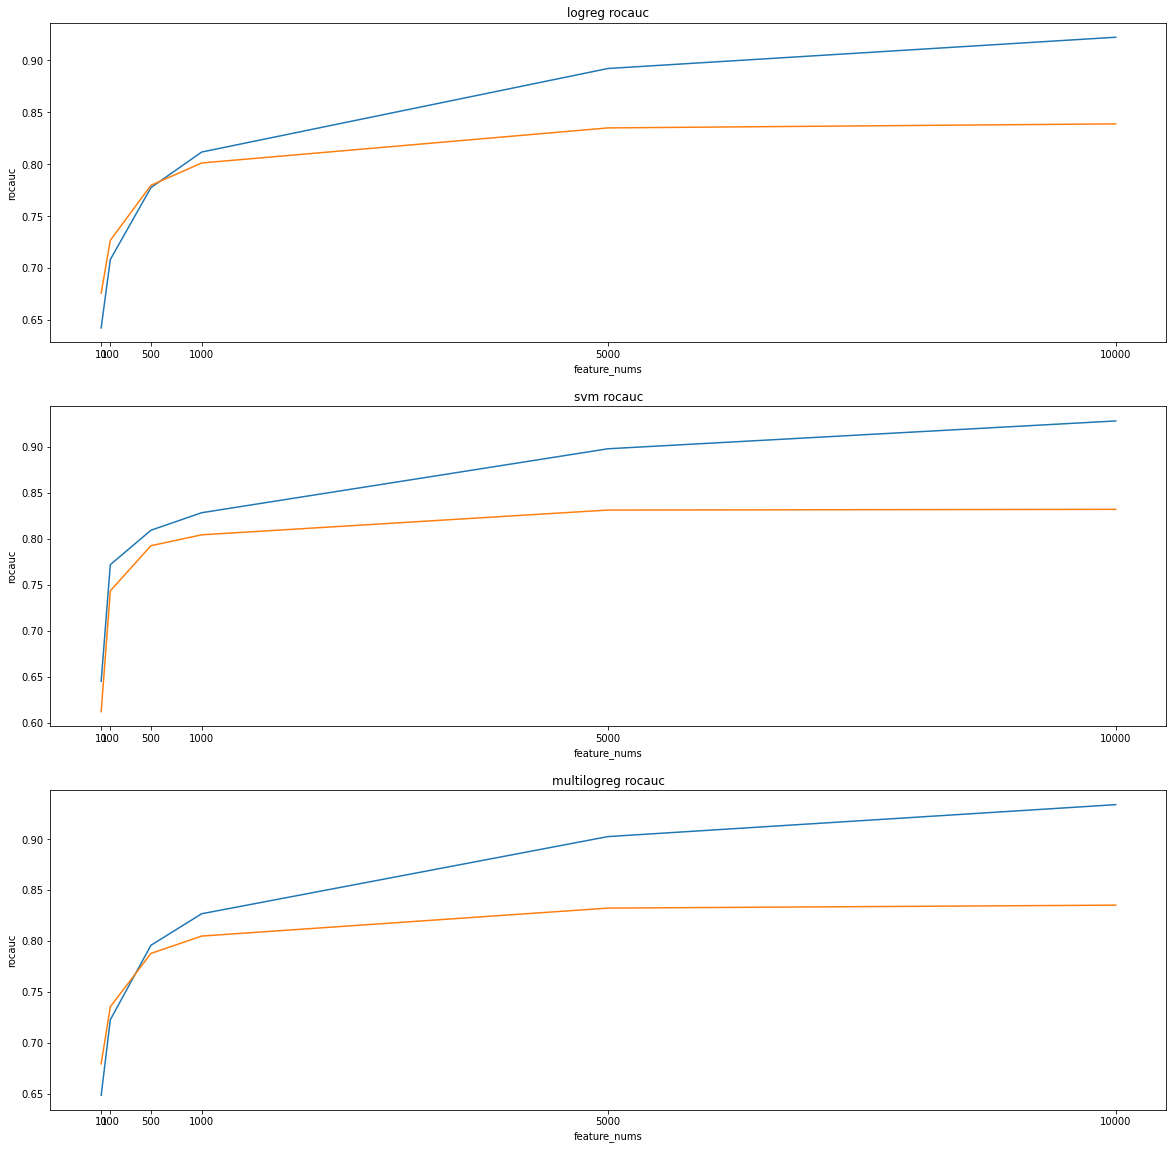

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1)
fig.set_figheight(20)
fig.set_figwidth(20)
for i, model_name in enumerate(auc_roc):
    ax[i].plot(*zip(*auc_roc[model_name]["train"]))
    ax[i].plot(*zip(*auc_roc[model_name]["test"]))
    ax[i].set_title(model_name + " rocauc")
    ax[i].xaxis.set_ticks(feature_nums)
    ax[i].set_xlabel('feature_nums')
    ax[i].set_ylabel('rocauc')
    
plt.show()


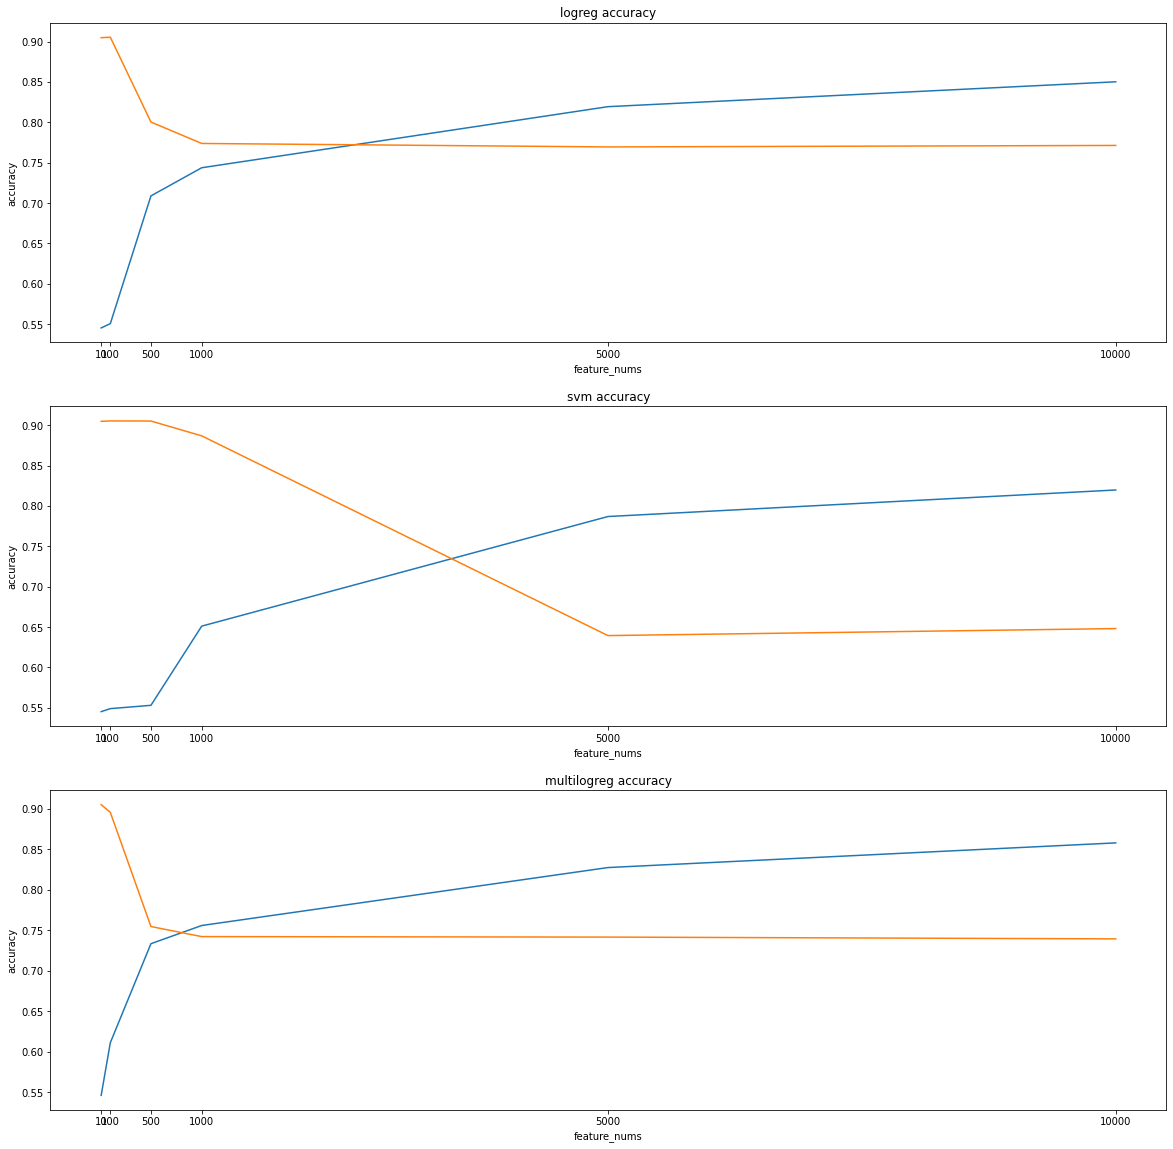

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1)
fig.set_figheight(20)
fig.set_figwidth(20)
for i, model_name in enumerate(accuracy):
    ax[i].plot(*zip(*accuracy[model_name]["train"]))
    ax[i].plot(*zip(*accuracy[model_name]["test"]))
    ax[i].set_title(model_name + " accuracy")
    ax[i].xaxis.set_ticks(feature_nums)
    ax[i].set_xlabel('feature_nums')
    ax[i].set_ylabel('accuracy')
    
plt.show()

Видно, что оптимальное число фичей равно 5000.
До этого числа на графиках видно недообучение, а с ростом rocauc и точность меняются незначительно

## Word2Vec

In [24]:
from pyspark.ml.feature import Word2Vec

def make_word2vec_pipeline():
    stop_words = ["the", "is", "are", "am", "to", " ", "\n", "t", "m", "re", "ll", "s"]
    tokenizer = Tokenizer(inputCol="comment_text", outputCol="comment_words")
    stopwordsRemover = StopWordsRemover(inputCol="comment_words", outputCol="filtered_words", stopWords=stop_words)
    ngram = NGram(n=1, inputCol="filtered_words", outputCol="ngram_words")
    word2vec = Word2Vec(vectorSize=1000, minCount=5, inputCol="ngram_words", outputCol="features")
    pipeline = Pipeline(stages=[tokenizer, stopwordsRemover, ngram, word2vec])
    return pipeline

In [25]:
pipeline = make_word2vec_pipeline()

### Logistic Regression

In [26]:
%%time

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="toxic", maxIter=100, regParam=1.0)

train_and_test(pipeline, lr, comments_with_labels, comments_test)

LogisticRegression_d9c43a168b89
Train rocauc: 0.9392144974217103
Train accuracy: 0.8586435734904622
Test rocauc: 0.9160554302924349
Test accuracy: 0.8529181906280284
CPU times: user 1.16 s, sys: 182 ms, total: 1.35 s
Wall time: 3min 17s


(LogisticRegressionModel: uid=LogisticRegression_d9c43a168b89, numClasses=2, numFeatures=1000,
 PipelineModel_d739900c2047,
 {'train': {'rocauc': 0.9392126832516241, 'accuracy': 0.8586435734904622},
  'test': {'rocauc': 0.9160554302924349, 'accuracy': 0.8529181906280284}})

### Linear SVM

In [27]:
%%time

from pyspark.ml.classification import LinearSVC

svm = LinearSVC(featuresCol="features", labelCol="toxic", maxIter=100, regParam=1.0)
train_and_test(pipeline, svm, comments_with_labels, comments_test)

LinearSVC_db721756cf4b
Train rocauc: 0.944526530284074
Train accuracy: 0.8664404963842514
Test rocauc: 0.9205971573214029
Test accuracy: 0.850917502891619
CPU times: user 1.11 s, sys: 186 ms, total: 1.29 s
Wall time: 3min 22s


(LinearSVCModel: uid=LinearSVC_db721756cf4b, numClasses=2, numFeatures=1000,
 PipelineModel_1c0ceedc3030,
 {'train': {'rocauc': 0.9445261910199825, 'accuracy': 0.8664404963842514},
  'test': {'rocauc': 0.9205971573214029, 'accuracy': 0.850917502891619}})

### Multinomial Logistic Regression

In [28]:
%%time

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="toxic", maxIter=100, regParam=1.0, family="multinomial")

train_and_test(pipeline, lr, comments_with_labels, comments_test)

LogisticRegression_badb420564c1
Train rocauc: 0.9425979085632992
Train accuracy: 0.8647144600184508
Test rocauc: 0.919113260213254
Test accuracy: 0.8490105973928538
CPU times: user 1.1 s, sys: 154 ms, total: 1.26 s
Wall time: 3min 16s


(LogisticRegressionModel: uid=LogisticRegression_badb420564c1, numClasses=2, numFeatures=1000,
 PipelineModel_0ddc0b462f2c,
 {'train': {'rocauc': 0.9425964211580998, 'accuracy': 0.8647144600184508},
  'test': {'rocauc': 0.919113260213254, 'accuracy': 0.8490105973928538}})

 Word2Vec дает лучшее качество модели при тех же параметрах